In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from PIL import Image
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import optuna

import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

from mlflow import MlflowClient
import requests

## Table of content
- [0. COVID-19 Dataset](#0.-COVID-19 Dataset)

## COVID-19 Dataset
#### COVID-19 patient's symptoms, status, and medical history.

#### About Dataset

This dataset is taken from Kaggle platform (https://www.kaggle.com/datasets/meirnizri/covid19-dataset)  


##### Context  

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.

##### content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [4]:
data = pd.read_csv('data/Covid_data.csv')
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [5]:
missing_values_count = data.apply(lambda col: col.isin([97, 99]).sum())
missing_values_count

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        221
PREGNANT                523511
DIABETES                     0
COPD                         0
ASTHMA                       0
INMSUPR                      0
HIPERTENSION                 0
OTHER_DISEASE                0
CARDIOVASCULAR               0
OBESITY                      0
RENAL_CHRONIC                0
TOBACCO                      0
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

In [6]:
data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

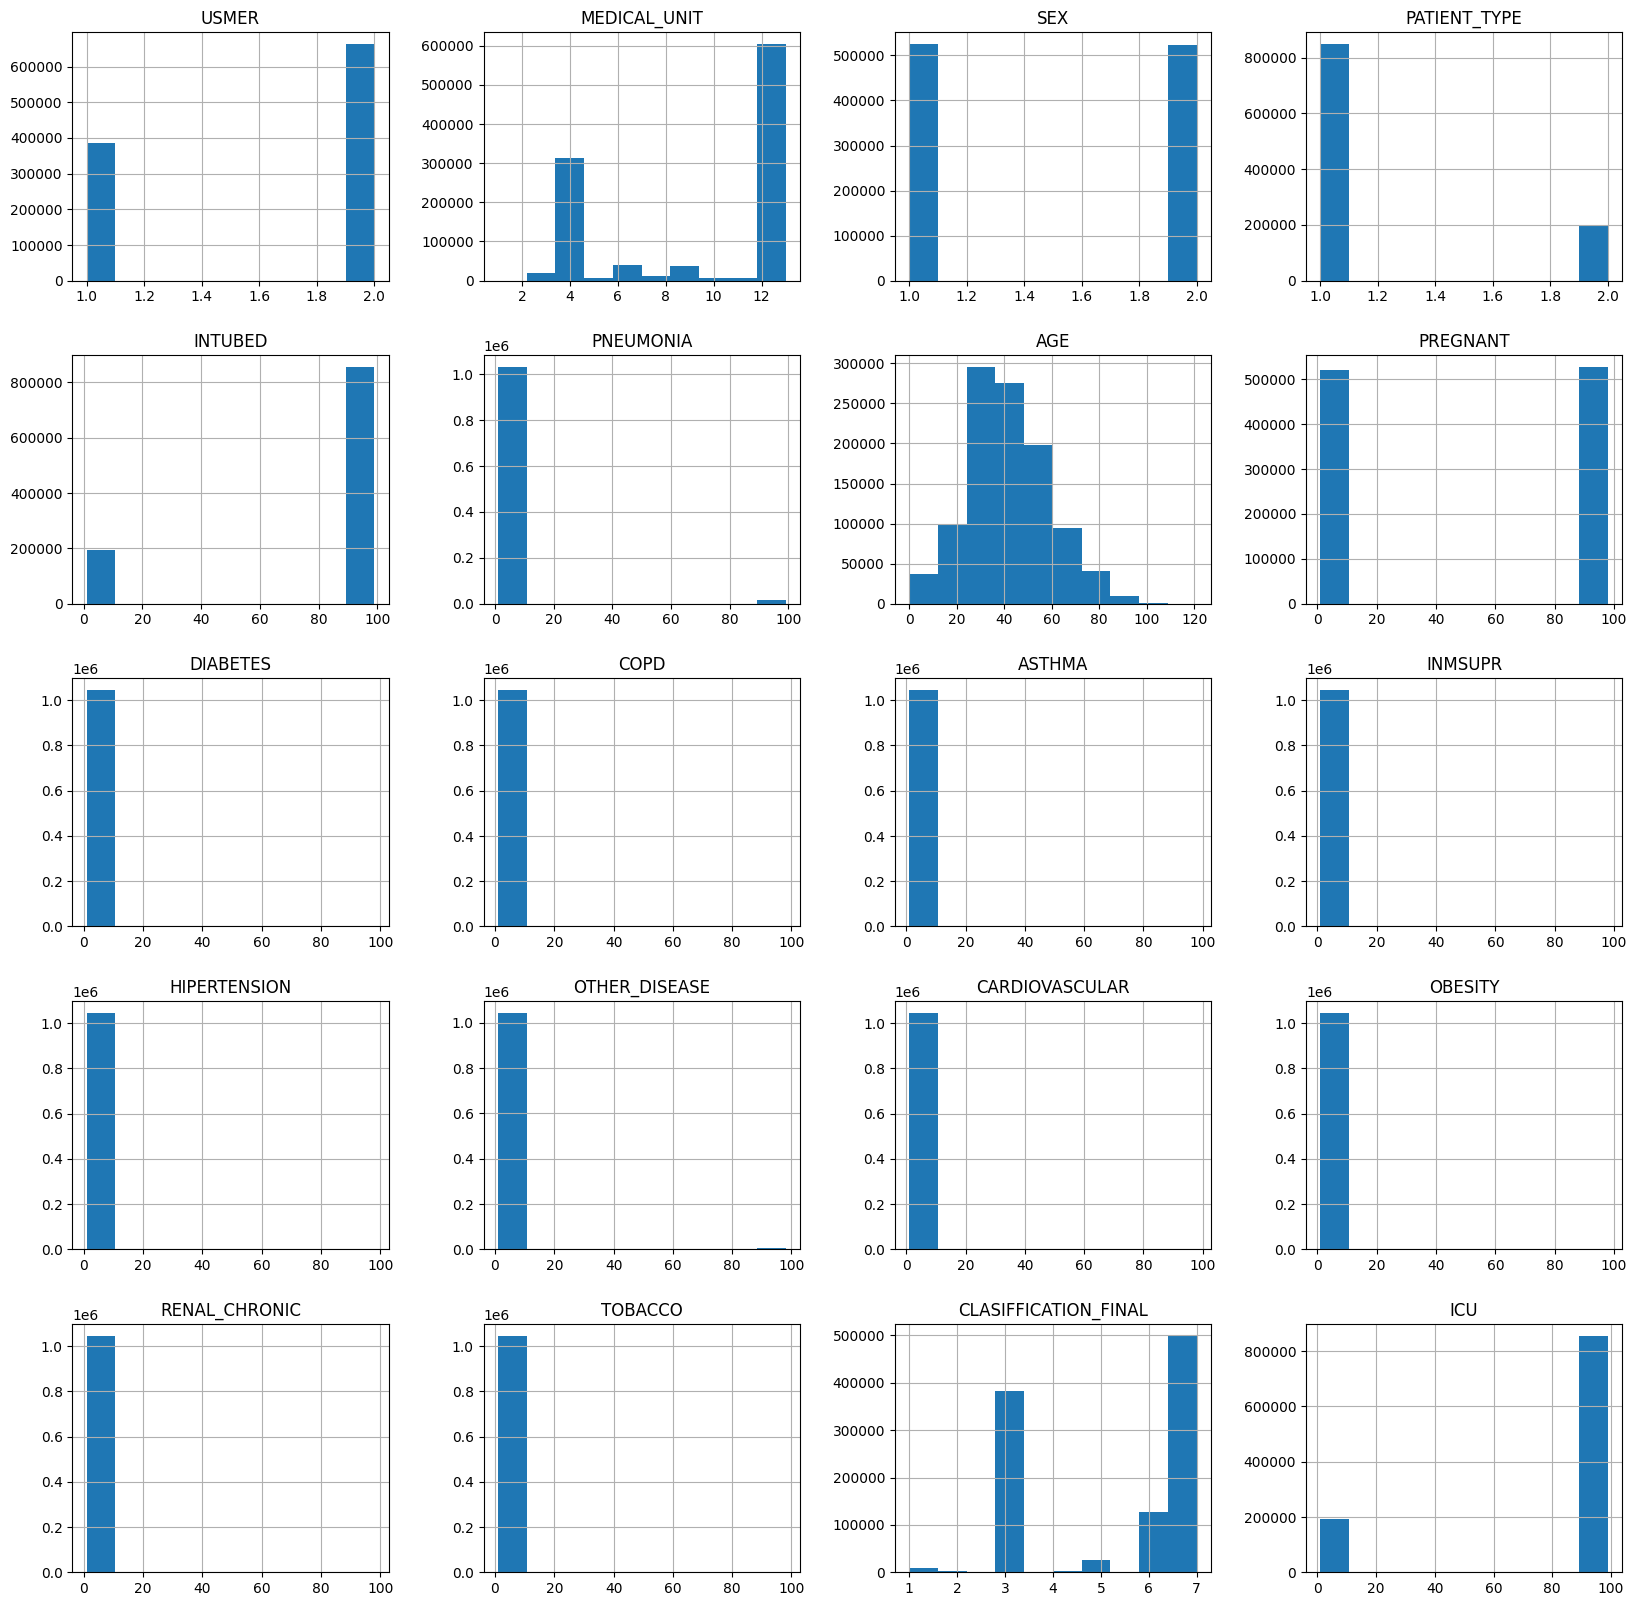

In [19]:
data.hist(figsize=(20, 20));

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [31]:
# let's make this classification task
data.loc[data['DATE_DIED'] == '9999-99-99','DATE_DIED'] = 0
data.loc[data['DATE_DIED'] != '9999-99-99','DATE_DIED'] = 1
data

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,1,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,1,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,1,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,1,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,1,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,1,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,1,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [32]:
X = data.drop('DATE_DIED',axis=1)
y = data['DATE_DIED']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.7, random_state=13)


In [36]:
X_train

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
975424,2,12,1,1,97,2,55,2,1,2,2,2,2,2,2,2,2,1,7,97
576055,2,12,2,1,97,2,31,97,2,2,2,2,2,2,2,2,2,2,3,97
443085,2,11,2,1,97,2,26,97,2,2,2,2,2,2,2,2,2,2,6,97
991265,2,12,2,1,97,2,32,97,2,2,2,2,2,2,2,2,2,1,7,97
931752,1,12,1,1,97,2,46,2,2,2,1,2,2,2,2,1,2,2,7,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536942,1,12,1,1,97,2,29,2,2,2,2,2,2,2,2,2,2,2,3,97
209144,1,4,2,1,97,2,48,97,1,2,2,2,2,2,2,2,2,2,6,97
347785,2,6,1,1,97,2,69,2,2,2,2,2,1,2,2,1,2,2,1,97
406880,2,9,1,1,97,2,24,2,2,2,2,2,2,2,2,2,2,2,3,97


### Pipeline

In [52]:
numerical_features = ['AGE']

categorical_features = [i for i in X_train.columns if i not in numerical_features]

# numeric data pipeline
pipe_num = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # not necessary because we have already clean data 
    ('power_tr', PowerTransformer()),
    ('scaler', StandardScaler()) ])

# cat data pipeline
pipe_cat = Pipeline([
    # ('imputer', SimpleImputer(strategy='constant',fill_value='unknown')), # not necessary because we have already clean data 
    ('encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])

# column transformer
ct = ColumnTransformer([
    ('pipe_num', pipe_num, numerical_features),
    ('pipe_cat', pipe_cat, categorical_features) ])